In [1]:
# %matplotlib widget
import numpy as np
import scipy as sp
import scipy.fftpack
import skimage
import skimage.filters
from skimage.transform import resize
from skimage.restoration import unwrap_phase

import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')
plt.style.use('grid')
from matplotlib.ticker import FormatStrFormatter

from pathlib import Path
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
from scipy import ndimage, misc
from PIL import Image
plt.rcParams["figure.figsize"] = (3.5, 2.5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["lines.linewidth"] = 0.5

In [2]:
folder = "corning"

# corning
AOI_X = 600
AOI_Y = 250
AOI_SIZE = 75

# optotune
AOI_Y = 750
AOI_X = 620
AOI_SIZE = 75

files = os.listdir(folder)
files.sort(key=lambda x: os.path.getctime(os.path.join(folder, x)))      
# files = files[1000::]

In [3]:
class sample:
    def __init__(self, filename):
        properties = filename[0:-4].split("_")
        self.filename = filename
        self.number = int(properties[0])
        self.time = float(properties[1])
        self.command = float(properties[2])
        self.temperature = float(properties[3])
        self.pressure = float(properties[4])
        self.a_x = float(properties[5])
        self.a_y = float(properties[6])
        self.a_z = float(properties[7])
        self.a = np.sqrt(self.a_x ** 2 + self.a_y ** 2 + self.a_z ** 2)
        self.g_x = float(properties[8])
        self.g_y = float(properties[9])
        self.g_z = float(properties[10])
        self.m_x = float(properties[11])
        self.m_y = float(properties[12])
        self.m_z = float(properties[13])
        
    def load(self):
#         print(self.filename)
        return np.load(os.path.join(folder, self.filename))['arr_0']#[AOI_Y - AOI_SIZE:AOI_Y + AOI_SIZE,AOI_X - AOI_SIZE:AOI_X + AOI_SIZE]
    
    def spot_area(self):
        img = self.load()
        return np.sum(img > 8) # arbitrarily chosen
    
    def __repr__(self):
        return (f"n: {self.number} t: {self.time} cmd: {self.command} temp: {self.temperature} p: {self.pressure} a: {self.a}")
    
def plotSample():
    plt.imshow(sample.load())
    plt.show()

In [4]:
samples = [sample(x) for x in files]
t0 = samples[0].time
print(samples[1500].time)

1621706819.26


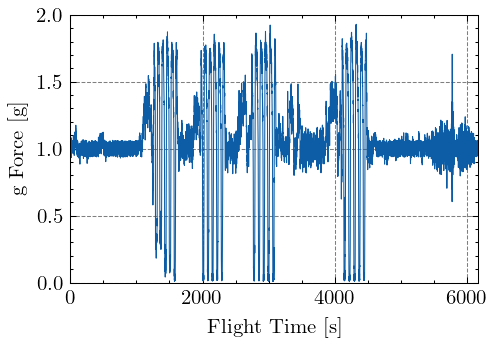

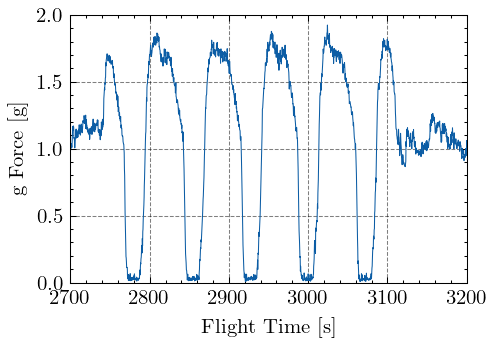

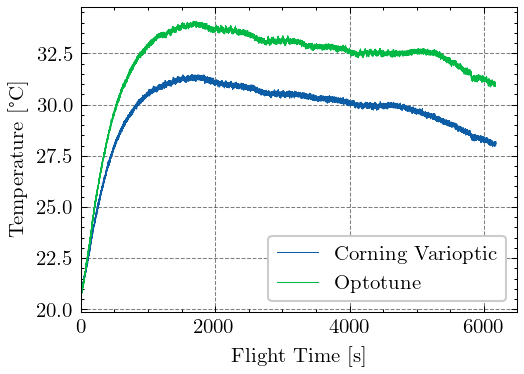

In [5]:
# print some acceleration data just so we know
t0 = samples[0].time
t = list(map(lambda x: x.time - t0, samples))
accel = list(map(lambda x: x.a, samples))
plt.plot(t, accel, linewidth=0.5)
plt.xlabel('Flight Time [s]')
plt.xlim(0, samples[-1].time - t0)
plt.ylim(0, 2.0)
plt.ylabel('g Force [g]')
# plt.grid()
plt.tight_layout()
plt.savefig("zerog_profile.pdf")  
plt.show()

plt.plot(t, accel, linewidth=0.5)
plt.xlabel('Flight Time [s]')
plt.xlim(0, samples[-1].time - t0)
plt.xlim(2700, 3200)
plt.ylim(0, 2)
plt.ylabel('g Force [g]')
# plt.grid()
plt.tight_layout()
plt.savefig('zerog_anatomy.pdf')  
plt.show()

plt.hist(accel, bins=np.linspace(0, 2, 17))
plt.xlim(0, 2)
plt.ylim(0, 7000)
plt.ylabel("Samples [-]")
plt.xlabel("g Force [g]")
# plt.yscale("log")
# plt.grid()
plt.tight_layout()
plt.savefig('zerog_hist.pdf')  
plt.show()

plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
plt.plot(np.load("time_optotune.npy"), np.load("temp_optotune.npy"))
plt.tight_layout()
plt.legend(["Corning Varioptic", "Optotune"])
# plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.savefig('temperature_both.pdf')  
plt.show()


In [6]:
samples_0g = [x for x in samples if x.a < 0.3]
samples_1g = [x for x in samples if x.a < 1.1 and x.a > 0.9]
samples_hg = [x for x in samples if x.a > 1.5]

print(f"0g: {len(samples_0g)}, 1g: {len(samples_1g)}, hg: {len(samples_hg)}")

0g: 1287, 1g: 12641, hg: 2169


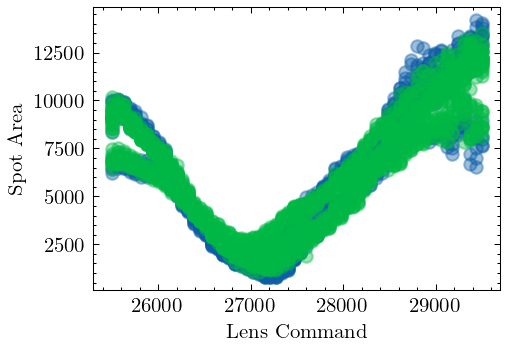

In [9]:
# plt.plot(list(map(lambda x: x.time, samples)), list(map(lambda x: x.pressure, samples)))

cmds_0g = [x.command for x in samples_0g]
spots_0g = [x.spot_area() for x in samples_0g]

cmds_1g = [x.command for x in samples_1g]
spots_1g = [x.spot_area() for x in samples_1g]

cmds_hg = [x.command for x in samples_hg]
spots_hg = [x.spot_area() for x in samples_hg]

plt.scatter(cmds_0g, spots_0g, alpha=0.4)
plt.scatter(cmds_hg, spots_hg, alpha=0.4)
plt.xlabel('Lens Command')
plt.ylabel('Spot Area')
plt.grid()
plt.show()


In [9]:
# image_1g = samples_1g[500].load()

focal_cmd = 27214
focal_cmds = np.unique([x.command for x in samples_0g])
# [25500. 25563. 25626. 25690. 25753. 25817. 25880. 25944. 26007. 26071.
#  26134. 26198. 26261. 26325. 26388. 26452. 26515. 26579. 26642. 26706.
#  26769. 26833. 26896. 26960. 27023. 27087. 27150. 27214. 27277. 27341.
#  27404. 27468. 27531. 27595. 27658. 27722. 27785. 27849. 27912. 27976.
#  28039. 28103. 28166. 28230. 28293. 28357. 28420. 28484. 28547. 28611.
#  28674. 28738. 28801. 28865. 28928. 28992. 29055. 29119. 29182. 29246.
#  29309. 29373. 29436. 29500.]
focal_samples_1g = [x for x in samples_1g if x.command == focal_cmd]
focal_samples_0g = [x for x in samples_0g if x.command == focal_cmd]
focal_samples_hg = [x for x in samples_hg if x.command == focal_cmd]

print(f"0g: {len(focal_samples_0g)}, 1g: {len(focal_samples_1g)}, hg: {len(focal_samples_hg)}")
spot_img = np.mean([x.load() for x in focal_samples_0g], 0) + np.mean([x.load() for x in focal_samples_hg], 0) +np.mean([x.load() for x in focal_samples_1g], 0)
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
plt.xlim(570-30, 620+30)
plt.ylim(310-20, 190+20)
# plt.title("Average Focused Spots in 0g, 1g, and 1.5+g")
plt.tight_layout()
plt.grid()
# plt.gcf().set_dpi(900)
cb1 = plt.colorbar()
cb1.set_label("Normalized Pixel Value [-]")
plt.savefig("corning_zerog_spots.png", dpi=600)
plt.show()

0g: 20, 1g: 206, hg: 37


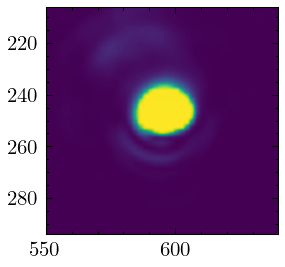

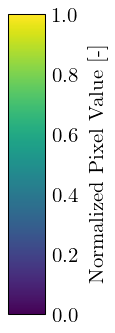

In [9]:
spot_sample_n = 10


spot_img = focal_samples_0g[spot_sample_n].load()
plt.figure(figsize=(2,2))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
plt.xlim(570-20, 620+20)
plt.ylim(310-20, 190+20)
plt.grid()
plt.savefig("spot_corning_0g.pdf")
plt.show()

spot_img = focal_samples_1g[spot_sample_n].load()
plt.figure(figsize=(2,2))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
plt.xlim(570-20, 620+20)
plt.ylim(310-20, 190+20)
plt.grid()
plt.savefig("spot_corning_1g.pdf")
plt.show()

spot_img = focal_samples_hg[spot_sample_n].load()
plt.figure(figsize=(2,2))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
plt.xlim(570-20, 620+20)
plt.ylim(310-20, 190+20)
plt.grid()
plt.savefig("spot_corning_hg.pdf")
plt.show()
    
fig = plt.figure(figsize=(0.25, 2))
ax1 = fig.add_axes([0.0, 1, 1, 1])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, orientation='vertical')
cb1.set_label("Normalized Pixel Value [-]")
plt.savefig("colorbar.pdf")
plt.show()


In [40]:
L = 120e-3 # mm from lens
com_upright = (288.94992782335436, 647.1881038234811)
com_0g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_0g], 0))
com_1g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_1g], 0))
com_hg = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_hg], 0))

print(1000 * (com_0g[0] - com_1g[0]) * (2 * 2.2e-6) / (L))
print(1000 * (com_0g[0] - com_hg[0]) * (2 * 2.2e-6) / (L))
print(com_0g)
print(com_1g)
# plt.imshow(np.mean([x.load() for x in focal_samples_1g], 0))

0.7409076332558233
1.2879465931295344
(257.42066333412384, 590.9084049238589, 0.0)
(237.21409151805594, 591.5054562171463, 0.0)


In [94]:
# calculate sd and mean for each spot area?
spot_mean_0g = []
spot_sd_0g = []

spot_mean_hg = []
spot_sd_hg = []

spot_mean_1g = []
spot_sd_1g = []

focal_cmds = np.unique([x.command for x in samples_0g])
spots_0g = []
spots_hg = []
spots_1g = []

for c in focal_cmds:
    f_samples_0g = [x for x in samples_0g if x.command == c]
    f_samples_hg = [x for x in samples_hg if x.command == c]
    f_samples_1g = [x for x in samples_1g if x.command == c]
    
    appended_spots_0g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_0g]
    spots_0g += appended_spots_0g
    
    appended_spots_hg = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_hg]
    spots_hg += appended_spots_hg
    
    appended_spots_1g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_1g if x.spot_area() > 0]
    spots_1g += appended_spots_1g
    
    spot_mean_0g.append(np.mean([x[1] for x in appended_spots_0g]))
    spot_sd_0g.append(np.std([x[1] for x in appended_spots_0g]))
    
    spot_mean_hg.append(np.mean([x[1] for x in appended_spots_hg]))
    spot_sd_hg.append(np.std([x[1] for x in appended_spots_hg]))
    
    spot_mean_1g.append(np.mean([x[1] for x in appended_spots_1g]))
    spot_sd_1g.append(np.std([x[1] for x in appended_spots_1g]))
       
# this is stupid
spot_mean_0g = np.array(spot_mean_0g)
spot_sd_0g = np.array(spot_sd_0g)
spot_mean_hg = np.array(spot_mean_hg)
spot_sd_hg = np.array(spot_sd_hg)
spot_mean_1g = np.array(spot_mean_1g)
spot_sd_1g = np.array(spot_sd_1g)

In [95]:
def hyperb(x, a, b, c, d):
    return a + np.sqrt(b + d * np.square(x-c))

range_lower = 8
range_upper = 39
cmd_lower = focal_cmds[range_lower]
cmd_upper = focal_cmds[range_upper]

# do a curve fit...
spots_0g_filt = [x for x in spots_0g if x[0] <= cmd_upper and x[0] >= cmd_lower]
spots_1g_filt = [x for x in spots_1g if x[0] <= cmd_upper and x[0] >= cmd_lower]
spots_hg_filt = [x for x in spots_hg if x[0] <= cmd_upper and x[0] >= cmd_lower]

cmds_0g = np.array([x[0] for x in spots_0g_filt])
sqarea_0g = np.array([x[1] for x in spots_0g_filt])
# print(spot_mean_)
# print(spots_0g)

cmds_hg = np.array([x[0] for x in spots_hg_filt])
sqarea_hg = np.array([x[1] for x in spots_hg_filt])

cmds_1g = np.array([x[0] for x in spots_1g_filt])
sqarea_1g = np.array([x[1] for x in spots_1g_filt])
# print(hyperb(cmds_0g, 1, 1, 1))
# print(cmds_0g.shape)
# print(sqarea_0g.shape)



[1.76213119e+01 4.58926315e+02 2.70632597e+04 3.60829934e-03]
[1.11874142e+01 7.90536688e+02 2.71227220e+04 3.69653814e-03]
[4.52625533e+00 2.09140896e+02 5.13604631e+00 4.24680172e-04]
[1.79607229e+00 1.05943416e+02 1.64699346e+00 1.49105702e-04]
[2.84537597e+00 9.79668895e+01 4.63893308e+00 2.18132335e-04]
[1.76213119e+01 4.58926315e+02 2.70632597e+04 3.60829934e-03]
[1.11874142e+01 7.90536688e+02 2.71227220e+04 3.69653814e-03]
[2.84616078e+01 2.50098615e+02 2.70933529e+04 2.26723237e-03]


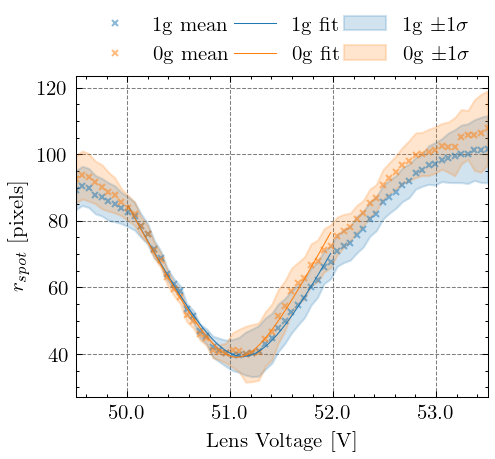

In [96]:
# [range_lower:range_upper]
# print(cmds_0g)
linsp = np.linspace(cmd_lower, cmd_upper)

plt.plot(linsp, hyperb(linsp, 30, 100, 27000, 0.003))
p0 = [30, 100, 27000, 0.003]
plt.plot(focal_cmds,(spot_mean_1g), 'x', color="tab:blue")
plt.plot(focal_cmds[range_lower:range_upper], spot_mean_1g[range_lower:range_upper], color="tab:orange")
plt.show()

popt_0g, pcov_0g = curve_fit(hyperb, cmds_0g, sqarea_0g, p0=p0)
popt_hg, pcov_hg = curve_fit(hyperb, cmds_hg, sqarea_hg, p0=p0)
popt_1g, pcov_1g = curve_fit(hyperb, cmds_1g, sqarea_1g, p0=p0)

print(popt_0g)
print(popt_1g)

plt.figure(figsize=(3.5, 3.25))
plt.plot(focal_cmds, spot_mean_1g, 'x', alpha=0.5, color="tab:blue", markersize=2.5)
plt.plot(focal_cmds, spot_mean_0g, 'x', alpha=0.5, color="tab:orange", markersize=2.5)
plt.plot(linsp, hyperb(linsp, *popt_1g), color="tab:blue")
plt.plot(linsp, hyperb(linsp, *popt_0g), color="tab:orange")
# plt.plot(linsp, hyperb(linsp, *popt_hg), color="tab:green")

print(np.sqrt(np.diag(pcov_0g)))
print(np.sqrt(np.diag(pcov_1g)))
print(np.sqrt(np.diag(pcov_hg)))

print(popt_0g)
print(popt_1g)
print(popt_hg)

# plt.plot(focal_cmds,(spot_mean_1g), 'x')
plt.fill_between(focal_cmds, (spot_mean_1g + spot_sd_1g), (spot_mean_1g - spot_sd_1g), alpha=0.2, color="tab:blue")
# plt.plot(focal_cmds, (spot_mean_0g), 'x')
plt.fill_between(focal_cmds, (spot_mean_0g + spot_sd_0g), (spot_mean_0g - spot_sd_0g), alpha=0.2, color="tab:orange")
# plt.plot(focal_cmds, (spot_mean_hg), 'x')
# plt.fill_between(focal_cmds, (spot_mean_hg + spot_sd_hg), (spot_mean_hg - spot_sd_hg), alpha=0.2)
plt.tight_layout()
# plt.grid()
plt.xlim(25500, 29500)

plt.xlabel("Lens Voltage [V]")
plt.ylabel("$r_{spot}$ [pixels]")
plt.legend(["1g mean", "0g mean", "1g fit", "0g fit", "1g $\pm 1 \sigma$", "0g $\pm 1 \sigma$"], loc='lower left', bbox_to_anchor=(0, 0.98, 1, 0.1), ncol=3, mode="expand",frameon=False)
plt.tight_layout()
plt.gca().xaxis.set_major_formatter(lambda x, pos: float(x)/1000 + 24)
plt.savefig("r_spot_corning.pdf")
plt.show()

In [98]:
print(popt_0g)
print(popt_1g)

[1.76213119e+01 4.58926315e+02 2.70632597e+04 3.60829934e-03]
[1.11874142e+01 7.90536688e+02 2.71227220e+04 3.69653814e-03]


In [31]:
plt.plot([x.time for x in samples_1g], [x.number for x in samples_1g], '.')

In [50]:
focal_samples = [x for x in samples if x.command == focal_cmd]

data_regress = [np.array([x.a for x in focal_samples]) , np.array([1000 * (com_0g[0] -ndimage.measurements.center_of_mass(x.load())[0]) * (2 * 2.2e-6) / (L) for x in focal_samples])]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_regress[0], data_regress[1])


0.7851555887929552


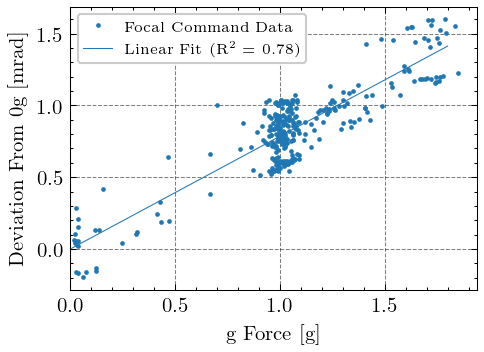

In [56]:
bias = -intercept
print(slope)
# plt.figure(figsize=(3.5, 3.25))
plt.plot(data_regress[0], data_regress[1] + bias, '.', markersize=2.5, alpha=1, color='tab:blue')
plt.plot([0, 1.8], [intercept + bias, intercept + bias + slope * 1.8], color='tab:blue')
plt.legend(["Focal Command Data", f"Linear Fit (R$^2$ = {r_value**2:.2f})"], fontsize='x-small')
plt.xlim(0)
plt.xlabel("g Force [g]")
plt.ylabel("Deviation From 0g [mrad]")
plt.savefig("corning_regression.pdf")
plt.show()

In [ ]:
plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
# plt.plot([x.time - t0 for x in samples_1g], [x.temperature for x in samples_1g], '.')
# plt.plot([x.time - t0 for x in samples_hg], [x.temperature for x in samples_hg], '.')
plt.plot(np.load("time_optotune.npy"), np.load("temp_optotune.npy"))
# plt.tight_layout()
plt.legend(["Corning Varioptic", "Optotune"], loc='lower right')
# plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.ylim(20, 35)
plt.savefig('temperature_both.pdf')  
plt.show()

plt.subplots(1,3, constrained_layout=False)
plt.subplot(1, 3, 1)
plt.hist([x.temperature for x in samples_1g], bins=np.arange(20, 33, 1), density=True, color='tab:blue', orientation="horizontal")
# plt.grid()
plt.ylim([20, 32])
plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.2, 0.4])
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_1g.pdf")
plt.subplot(1, 3, 2)
plt.hist([x.temperature for x in samples_0g], bins=np.arange(20, 33, 1), density=True, color='tab:orange', orientation="horizontal")
# plt.grid()
plt.ylim([20, 32])
# plt.ylabel("Temperature [°C]")
plt.xlabel("Proportion [-]")
plt.legend(["0g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.2, 0.4])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplot(1, 3, 3)
plt.hist([x.temperature for x in samples_hg], bins=np.arange(20, 33, 1), density=True, color='tab:green', orientation="horizontal")
# plt.grid()
plt.ylim([20, 32])
# plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1.5+g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.2, 0.4])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplots_adjust(wspace=0.25)
plt.savefig("temp_histo_corning.pdf")
plt.show()
# plt.hist([x.temperature for x in samples_0g], bins=np.arange(26, 32.5, 1), density=True, color='tab:orange')
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_0g.pdf")
# plt.show()
# plt.hist([x.temperature for x in samples_hg],bins=np.arange(26, 32.5, 1), density=True, color='tab:green')
# plt.tight_layout()
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.show()

[114.44212511134175, 115.51623262554921, 115.5551816233266, 110.46266337545913, 113.61337949379025, 116.44311916124542, 118.14397995666135, 117.44786077234443, 118.51160280748886, 110.57124400132251, 111.91514642799696, 115.7540496051866, 113.01327355669333, 109.00458705944443, 94.27088627991147, 90.32718306246464, 87.46999485537883, 87.52142594816426, 89.2972563968233]
16
8


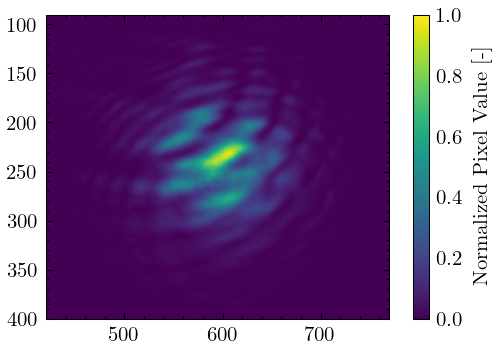

87.46999485537883
118.51160280748886


In [7]:
spot_areas = [np.sqrt(x.spot_area()) for x in samples_0g if x.command == 29500]
print(spot_areas)
print(np.argmin(spot_areas))
print(np.argmax(spot_areas))
sample1 = [x for x in samples_0g if x.command == 29500][16]
sample2 = [x for x in samples_0g if x.command == 29500][8]
img1 = sample1.load()
img2 = sample2.load()
plt.imshow(img1/np.max(img1))
plt.xlim(420, 770)
plt.ylim(400, 90)
# plt.axis("equal")
plt.tight_layout()
cb1 = plt.colorbar()
cb1.set_label("Normalized Pixel Value [-]")
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticks([])
# frame1.axes.yaxis.set_ticks([])
plt.grid()
plt.savefig("corning_high_rsw.pdf")

plt.show()
plt.imshow(img2/np.max(img2))
plt.xlim(420, 770)
plt.ylim(400, 90)
plt.tight_layout()
cb1 = plt.colorbar()
cb1.set_label("Normalized Pixel Value [-]")
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticks([])
# frame1.axes.yaxis.set_ticks([])

plt.grid()
plt.savefig("corning_low_rsw.pdf")
plt.show()
print(np.sqrt(sample1.spot_area()))
print(np.sqrt(sample2.spot_area()))

In [93]:
rsw_data = np.array([[x.spot_area(), sp.ndimage.center_of_mass(x.load())[0], sp.ndimage.center_of_mass(x.load())[1], x.a, x.a_x, x.a_y, x.a_z, x.g_x, x.g_y, x.g_z, x.m_x, x.m_y, + x.m_z, x.temperature, x.pressure, x.time - t0] for x in samples if x.command == 29500])
rsw_df = pd.DataFrame(rsw_data, columns = ['rsw', 'y centroid','x centroid', 'acceleration','a_x', 'a_y', 'a_z','g_x', 'g_y', 'g_z', 'm_x', 'm_y', 'm_z', 'temperature', 'pressure', 'time'])

In [99]:
rsw_corr = np.corrcoef(rsi_data.T);
sns.heatmap((rsw_df.corr()),cmap="PiYG",vmin=-1, vmax=1)
plt.show()
plt.plot(rsw_df['time'], rsw_df['pressure'], 'x')


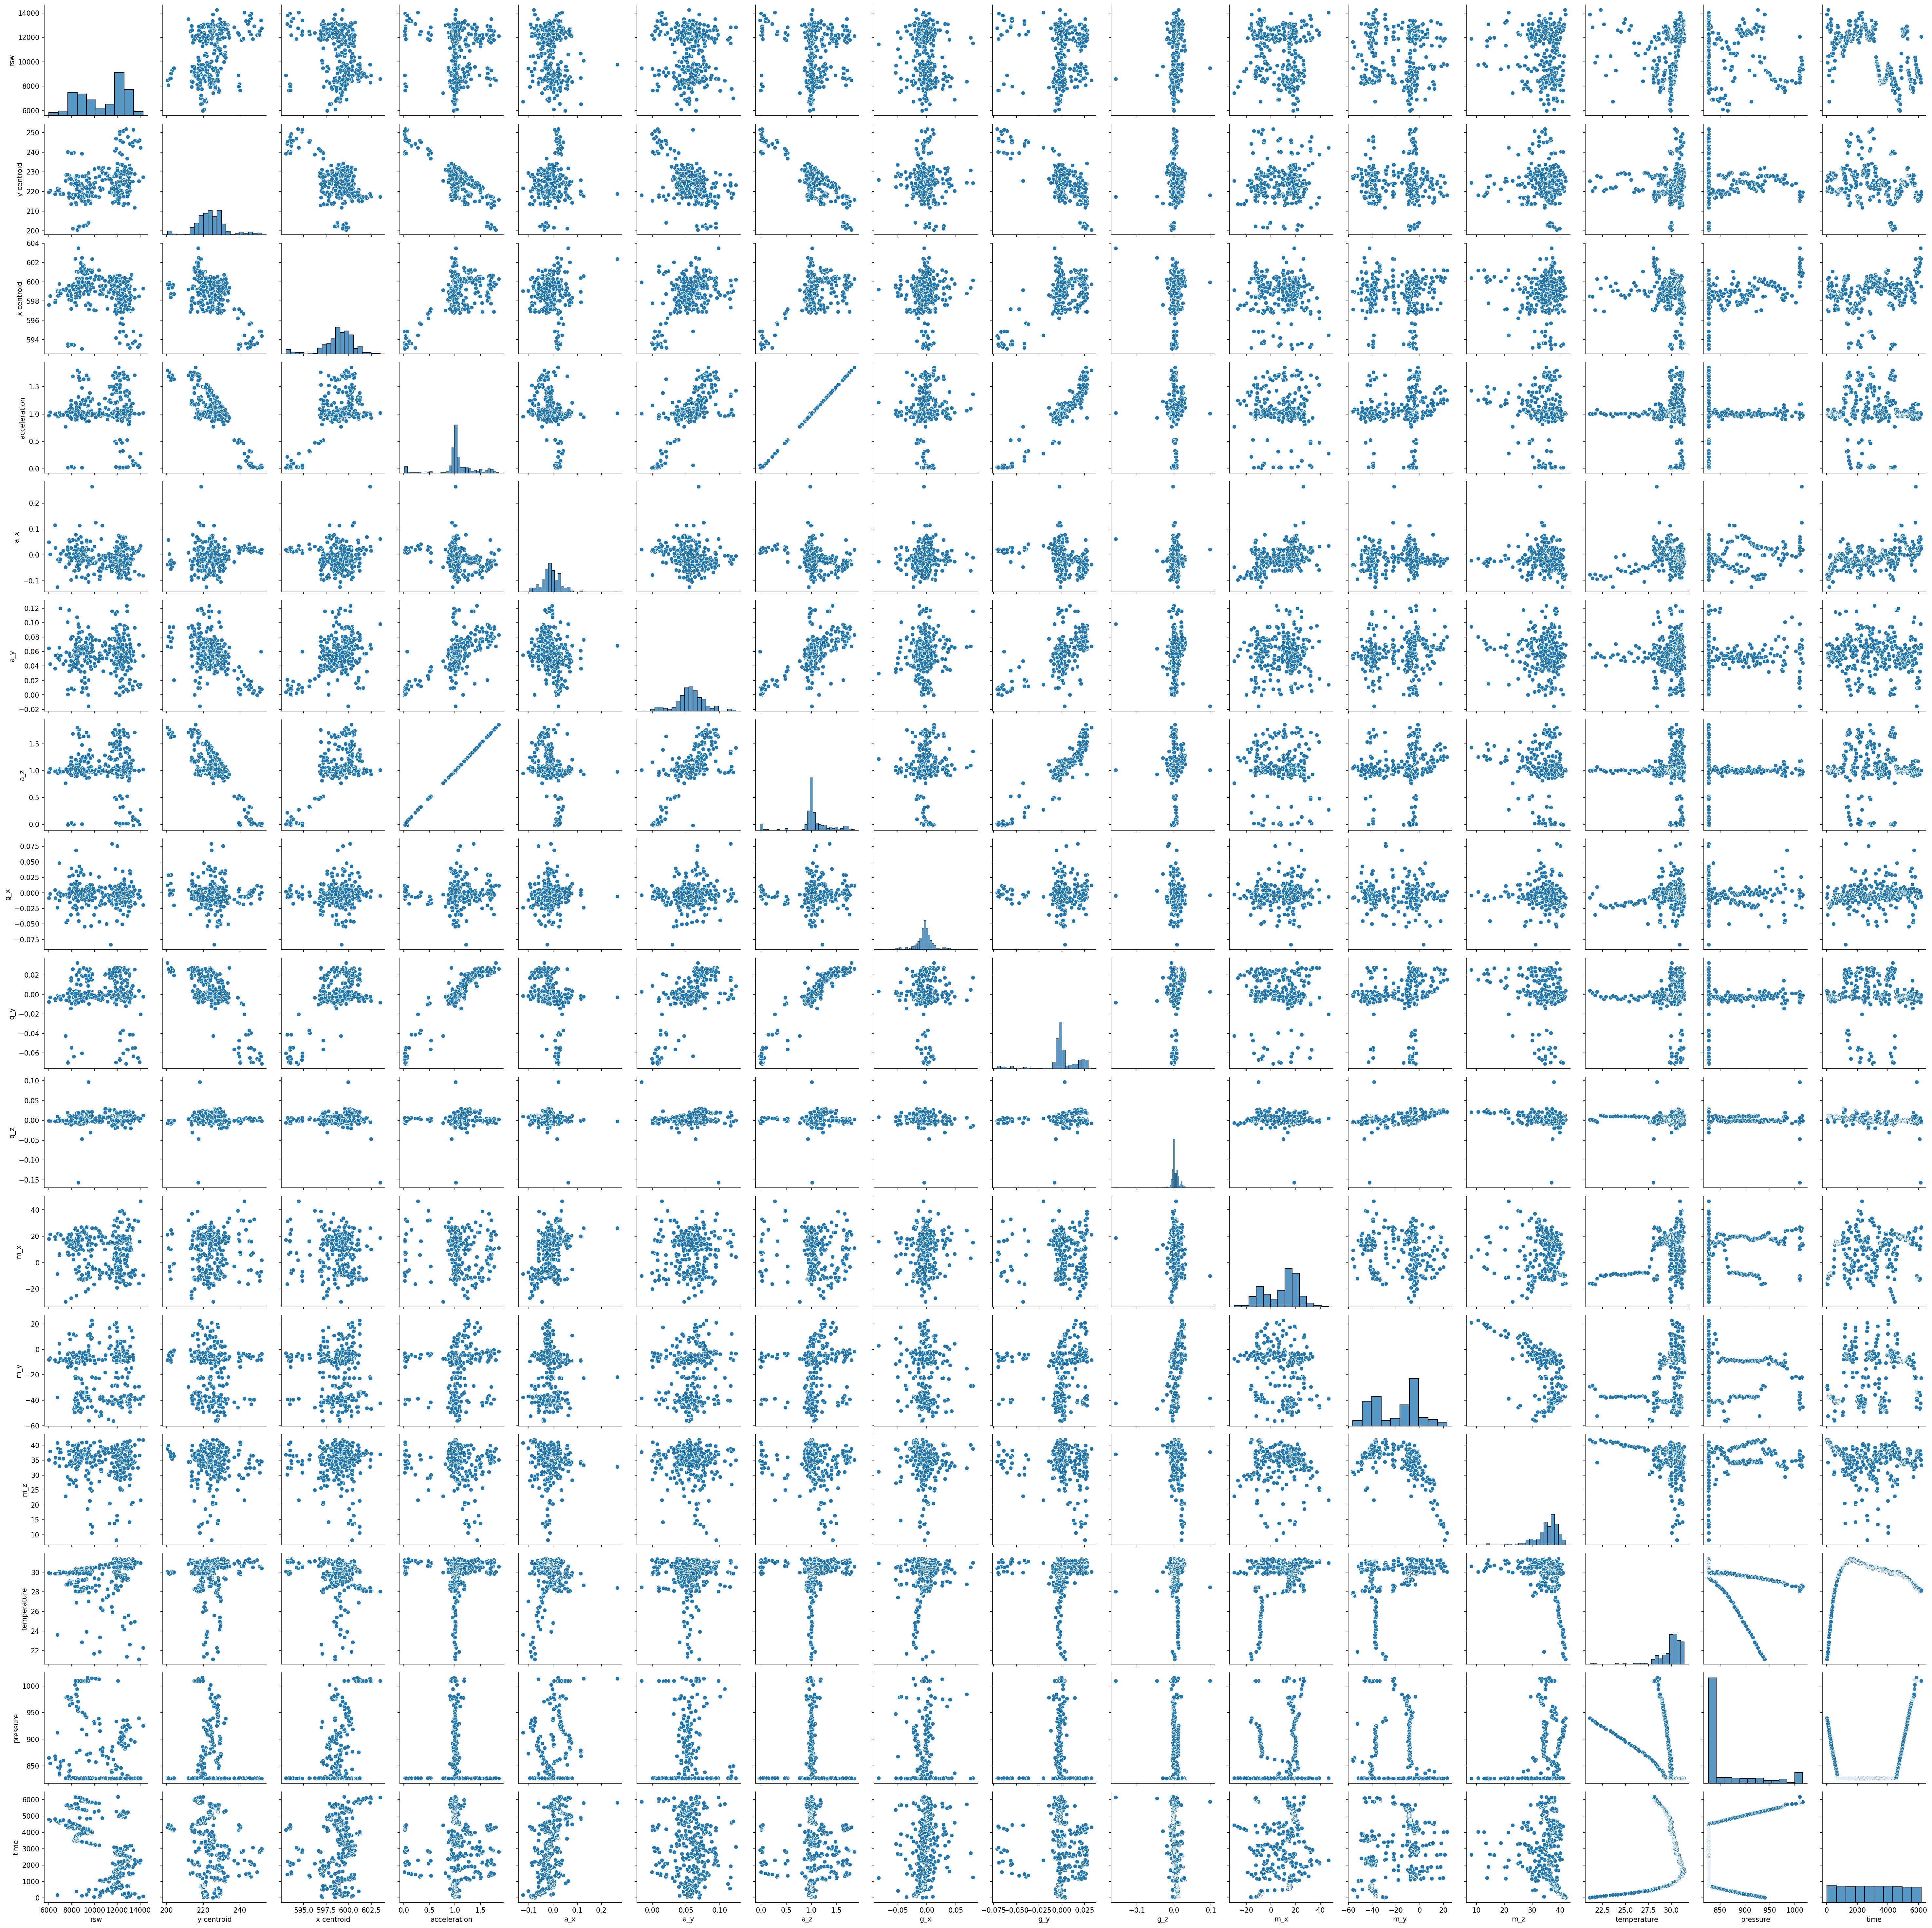

In [104]:
sns.pairplot(rsw_df)

In [89]:
sns.distplot(rsw_df['rsw'])

c:\users\shree\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rsw', ylabel='Density'>

In [102]:
# import scipy.fft
sp.fft.fht(img1, 1, 1)

AttributeError: module 'scipy.fft' has no attribute 'fht'